In [1]:
import numpy as np
import deeptrack as dt
import deeplay as dl
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import random


In [2]:

image = dt.LoadImage("cope_1.png")

plt.figure(figsize=(15, 10))
image = np.array(image.resolve()) #Note to self, resolve() makes it into a list
print(np.shape(image))
#plt.imshow(image)

(5202, 3464, 3)


<Figure size 1500x1000 with 0 Axes>

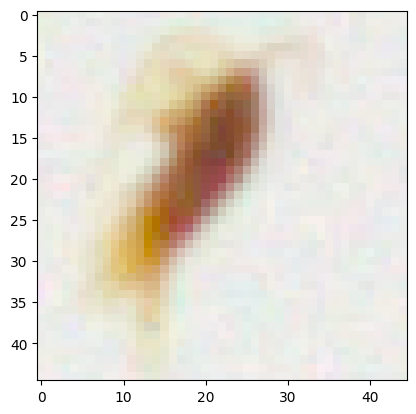

In [3]:
crop_size =45
y_index = 3087
x_index = 1773
x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])
plt.imshow(training_image)

# Prepare cropped sample

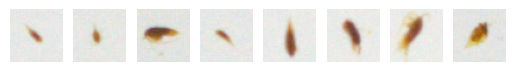

In [40]:

'''
crops from cope_2.png:

crop_size = 30
y_index = 1770
x_index = 608

crop_size = 35
y_index = 1675
x_index = 450
'''
 
crops = [45,45,45,45,45,45,45,45,45,45,45]
ys    = [1875,    1487,  955,1740,2693,2955,3087,1430 ] # ,1945,1970,1480,,2955,2345,1864,1525,
xs    = [1785,   1550,   2050,1825,2010,2040,1773,2395] #  ,1230,850,1595,,2040 1070, 920, 1517,
training_images = []
number_of_crops = len(ys)
#x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
#training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])


for i in range(number_of_crops):
    #go through the positions for the crops
    y_index   = ys[i]
    x_index   = xs[i]
    crop_size = 45
    x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
    training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])
    training_images.append(training_image)
    plt.subplot(1,number_of_crops,i+1)
    plt.axis("off")
    plt.imshow(training_image)


random_crop = dt.Value(lambda: random.choice(training_images))
#np.expand_dims(training_images, axis=-1)

    


In [41]:
downsample = 2
training_pipeline = (
    
    dt.Value(random_crop)
    >> dt.AveragePooling(ksize=(downsample, downsample, 1))
    #>> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2)
    >> dt.Multiply(lambda: np.random.uniform(0.95, 1.05))
    >> dt.Add(lambda: np.random.uniform(-0.07, 0.07))
    >> dt.MoveAxis(-1, 0)

    >> dt.pytorch.ToTensor(dtype=torch.float32)

)
training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, replace=False)

In [42]:
dataloader = dl.DataLoader(training_dataset,batch_size=8,shuffle=True,num_workers=6)

# Train LodeSTAR with cropped sample

In [43]:
epochs = 25
lodestar = dl.LodeSTAR(n_transforms=4,optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=epochs)
trainer.fit(lodestar,dataloader)

INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_lo

Epoch 24: 100%|██████████| 50/50 [00:03<00:00, 16.49it/s, v_num=67, train_between_image_disagreement_step=0.043, train_within_image_disagreement_step=0.017, train_between_image_disagreement_epoch=0.0497, train_within_image_disagreement_epoch=0.0219]   


# Evaluate Performance

(4161, 2771, 3)


Text(0.5, 1.0, 'Predicted image')

<Figure size 1500x1000 with 0 Axes>

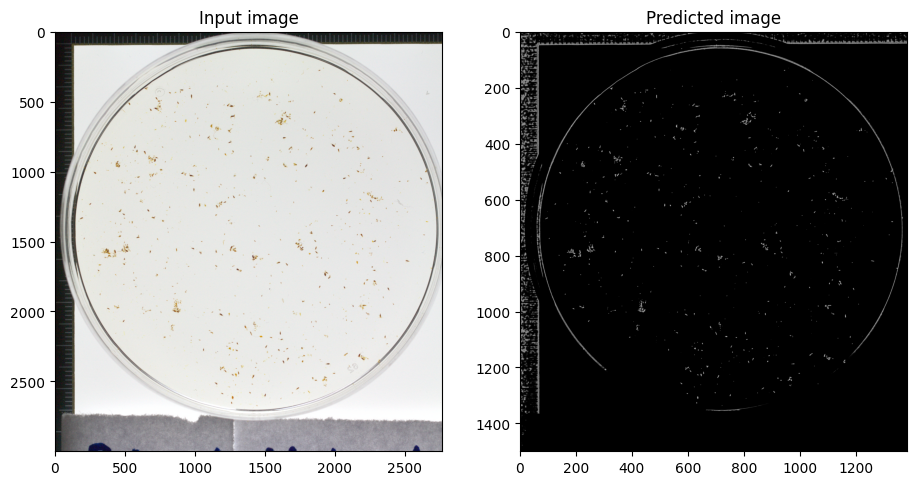

In [44]:

#Downsample test image so it can be fed without crashing the pc
#Try cope_2.png

image = dt.LoadImage("cope_1.png")
plt.figure(figsize=(15, 10))
image = np.array(image.resolve()) #Note to self, resolve() makes it into a list


import cv2
rescale_factor = 0.8
new_width  = int(image.shape[1]*rescale_factor)
new_height = int(image.shape[0]*rescale_factor)
test_image = cv2.resize(image, (new_width,new_height),interpolation=cv2.INTER_AREA) 
print(np.shape(test_image))
torch_image = torch.from_numpy(test_image[0:3000,:,:]).permute(2,0,1).unsqueeze(0).float()


#Feed to LodeSTAR
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho  = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(17,11))
plt.subplot(1,3,1)
plt.imshow(test_image[0:3000,:,:])
plt.title("Input image")

plt.subplot(1,3,2)
plt.imshow(rho,cmap="gray")
plt.title("Predicted image")


Detections: 507
Record = 533


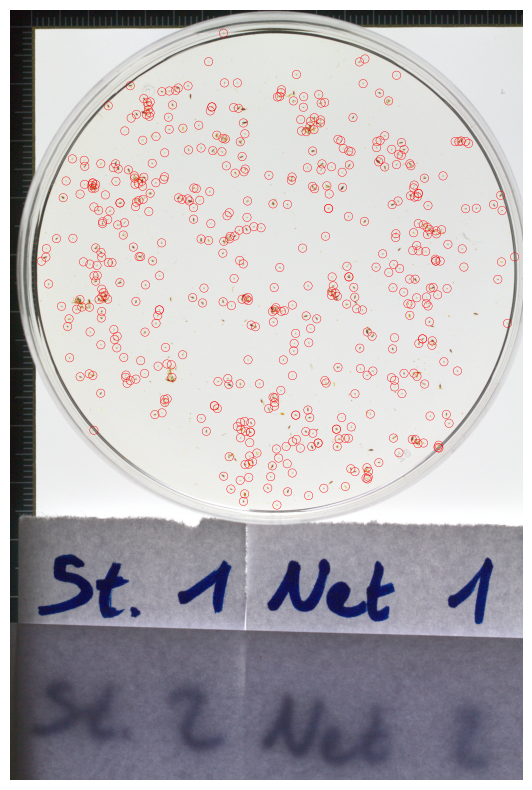

In [52]:
alpha = 0.5 #Dissimilarity parameter, higher = more dissimilar plankton
beta  = 1-alpha   #Clustering    parameter, higher = clusters need to be more well defined to be included
cutoff = 0.8  #0.75 for cope_1
mode= "constant"

detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                 mode="constant", cutoff=cutoff)[0]
detection_number = len(detections[:,1])                          
print(f"Detections: {detection_number}")
print(f"Record = 533")

plt.figure(figsize=(15, 10))
plt.imshow(test_image, cmap="gray")
plt.scatter(detections[:, 1], detections[:, 0],marker="o",facecolors="none",edgecolors='r',linewidths=0.3)
plt.axis("off")
plt.show()